## Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 15.7 MB/s eta 0:00:00


In [ ]:
!pip install neuralplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import random
from tensorflow.keras import Sequential,layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import statistics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import tensorflow_probability as tfp
from operator import truediv
from tensorflow.compat.v1.distributions import Bernoulli
from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import tensorflow as tf
from tensorflow.python.keras import backend as K
from neuralplot import ModelPlot

init_notebook_mode(connected=True)
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Initialization

In [ ]:
# Global variables
im_width, im_height, im_depth, im_channel = 11,11,30,1
mc_loss_weight = 5

## Model Construction

In [ ]:
def calc_euclidian_dists(x, y):
  # x : (n,d)
  # y : (m,d)
  n = x.shape[0] # 75
  m = y.shape[0] # 5
  # print('n:', n)
  # print('m:', m)
  # print('tf.expand_dims(x, 1) : ', tf.expand_dims(x, 1).shape)
  # print('tf.expand_dims(y, 0)', tf.expand_dims(y, 0).shape)
  x = tf.tile(tf.expand_dims(x, 1), [1, m, 1])
  y = tf.tile(tf.expand_dims(y, 0), [n, 1, 1])
  # print('x :', x.shape)
  # print('y :', y.shape)
  return tf.reduce_mean(tf.math.pow(x - y, 2), 2) # main calculation of distances

In [ ]:
def _bernoulli(shape, mean):
    return tf.nn.relu(tf.sign(mean - tf.random.uniform(shape, minval=0, maxval=1, dtype=tf.float32)))

In [ ]:
class DropBlock3D(tf.keras.layers.Layer):
    def __init__(self, keep_prob, block_size, scale=True, **kwargs):
        super(DropBlock3D, self).__init__(**kwargs)
        self.keep_prob = float(keep_prob) if isinstance(keep_prob, int) else keep_prob
        self.block_size = int(block_size)
        self.scale = tf.constant(scale, dtype=tf.bool) if isinstance(scale, bool) else scale

    def compute_output_shape(self, input_shape):
        return input_shape

    def build(self, input_shape):
        assert len(input_shape) == 5
        _, self.d, self.h, self.w, self.channel = input_shape.as_list()
        # pad the mask
        p0 = (self.block_size - 1) // 2
        p1 = (self.block_size - 1) - p0
        self.padding = [[0, 0], [p0, p1], [p0, p1], [p0, p1], [0, 0]]
        self.set_keep_prob()
        super(DropBlock3D, self).build(input_shape)

    def call(self, inputs, training=True, **kwargs):
        def drop():
            mask = self._create_mask(tf.shape(inputs))
            output = inputs * mask
            output = tf.cond(self.scale,
                             true_fn=lambda: output * tf.compat.v1.to_float(tf.size(mask)) / tf.reduce_sum(mask),
                             false_fn=lambda: output)
            return output

        if training is None:
            training = K.learning_phase()
        output = tf.cond(tf.logical_or(tf.logical_not(training), tf.equal(self.keep_prob, 1.0)),
                         true_fn=lambda: inputs,
                         false_fn=drop)
        return output

    def set_keep_prob(self, keep_prob=None):
        """This method only supports Eager Execution"""
        if keep_prob is not None:
            self.keep_prob = keep_prob
        d, w, h = tf.compat.v1.to_float(self.d), tf.compat.v1.to_float(self.w), tf.compat.v1.to_float(self.h)
        self.gamma = ((1. - self.keep_prob) * (d * w * h) / (self.block_size ** 3) /
                      ((d - self.block_size + 1) * (w - self.block_size + 1) * (h - self.block_size + 1)))

    def _create_mask(self, input_shape):
        sampling_mask_shape = tf.stack([input_shape[0],
                                        self.d - self.block_size + 1,
                                        self.h - self.block_size + 1,
                                        self.w - self.block_size + 1,
                                        self.channel])
        mask = _bernoulli(sampling_mask_shape, self.gamma)
        mask = tf.pad(mask, self.padding)
        mask = tf.nn.max_pool3d(mask, [1, self.block_size, self.block_size, self.block_size, 1], [1, 1, 1, 1, 1], 'SAME')
        mask = 1 - mask
        return mask

In [ ]:
input_layer = layers.Input(shape = (im_height, im_width, im_depth, im_channel))
out1 = layers.Conv3D(filters=8, kernel_size=(3,3,7), activation='relu',input_shape=(im_height, im_width, im_depth, im_channel),padding='same')(input_layer)
out1 = DropBlock3D(0.7,3)(out1) # Note: ready made library available
out2 = layers.Conv3D(filters=16, kernel_size=(3,3,5), activation='relu',padding='same')(out1)
out2 = DropBlock3D(0.7,3)(out2)
out3 = layers.Conv3D(filters=32, kernel_size=(3,3,3), activation= 'relu')(out2)
out3 = layers.Reshape((out3.shape[1], out3.shape[2], out3.shape[3]*out3.shape[4]))(out3)
out3 = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(out3)
out4 = layers.Flatten()(out3)
out4 = layers.Dropout(0.4)(out4, training=True)
out4 = layers.Dense(256, activation='relu')(out4)
out5 = layers.Dropout(0.4)(out4,training=True)
out5 = layers.Dense(128, activation='relu')(out5)
model = Model(inputs=input_layer,outputs=out5)
model.summary()


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11, 11, 30, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 11, 11, 30, 8)     512       
                                                                 
 drop_block3d (DropBlock3D)  (None, 11, 11, 30, 8)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 11, 11, 30, 16)    5776      
                                                                 
 drop_block3d_1 (DropBlock3D  (None, 11, 11, 30, 16)   0         
 )                                                               
                                                                 
 conv3d_2 (Conv3D)           (None, 9, 9, 28, 32)      13856     
                                                             

In [ ]:
modelplot = ModelPlot(model=model, grid=True, connection=True, linewidth=0.1)

In [ ]:
# modelplot.show()

In [ ]:
class Prototypical(Model):
    def __init__(self, model, w, h, d, c):
        super(Prototypical, self).__init__()
        self.w, self.h, self.d, self.c = w, h, d, c
        self.encoder = model

    def call(self, support, query, support_labels, query_labels, K, C, N,n_times,training=True):
      n_class = C                                                               #5
      n_support = K                                                             #5
      n_query = N                                                               #15

      if training == True :
        loss = 0
        mc_predictions = []                                                     # list of predictions for multiple passes
        for i in range(n_times) :                                               # 0-24
          y = np.zeros((int(C*N),C))                                            # (75,5)
          for i in range(int(C*N)) :                                            # 0-74
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for true labels
            y[i][x] = 1.                                                        # n_times passing every query image for calculating variance
          cat = tf.concat([support,query], axis = 0)                            # [100,11,11,30,1]
          z = self.encoder(cat)                                                 # (100, 128)
          # print("Shape of z:",z.shape)
          # Divide embedding into support and query
          z_prototypes = tf.reshape(z[:n_class * n_support],[n_class, n_support, z.shape[-1]])   # (5, 5, 128)
          # print("Shape of z_prototypes:",z_prototypes.shape)
          # Prototypes are means of n_support examples
          z_prototypes = tf.math.reduce_mean(z_prototypes, axis=1)              #[5, 128]
          # print("Shape of z_prototypes after reduce_mean:", z_prototypes.shape)
          z_query = z[n_class * n_support:]                                     #[75, 128]
          # print("z_query:",z_query.shape)
          # Calculate distances between query and prototypes
          dists = calc_euclidian_dists(z_query, z_prototypes)                   #[75, 5]
          # print("dists after euclidean_dist:", dists.shape)
          # log softmax of calculated distances
          log_p_y = tf.nn.log_softmax(-dists, axis=-1)                          #[75, 5]
          # print("log_p_y:", log_p_y.shape)
          loss1 = -tf.reduce_mean((tf.reduce_sum(tf.multiply(y, log_p_y), axis=-1))) #loss for the current pass
          # print("loss1:", loss1)
          loss += loss1                                                         # adding loss for each pass
          softmax_predictions = tf.nn.softmax(-dists, axis=-1)                          # prediction probability for the search-space classes per query image(for current pass)
          new_distance = dists/1.5                                              # temprature scalling ****
          predictions = tf.nn.softmax(-new_distance, axis=-1)                                 # prediction probability for the search-space classes per query image(for current pass)
          print('Loop Number : ', i)
          print("Dists : ", dists[0])
          print("A" * 10)

          print('New Distance : ', new_distance[0])
          print("B" * 10)
          print("Temperature scPredictions : ", predictions[0])
          print("C" * 10)
          mc_predictions.append(predictions)

        y = np.zeros((int(C*N),C))                                              # (75, 5)
        for i in range(int(C*N)) :                                              # 0-74
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for true labels
            y[i][x] = 1.
        mc_predictions = tf.convert_to_tensor(np.reshape(np.asarray(mc_predictions),(n_times,int(C*N),C)))  #(n_times=25,75,5)
        # print("mc_predictions:", mc_predictions.shape)
        std_predictions = tf.math.reduce_std(mc_predictions, axis=0)            # (75,5)
        # print("std_predictions:", std_predictions.shape)
        std = tf.reduce_sum(tf.reduce_sum(tf.multiply(std_predictions,y),axis=1))
        # print("std:", std)
        loss += mc_loss_weight*std
        temp_list.append(std)
        # calculating mean accuracy
        mean_predictions = tf.reduce_mean(mc_predictions,axis=0)                # mean prediction probability for each class (75,5)
        # print("mean_predictions after 1st reduce mean:", mean_predictions[0])# (75, 5)
        mean_eq = tf.cast(
            tf.equal(                                             # accuracy for the current pass
              tf.cast(tf.argmax(mean_predictions, axis=-1), tf.int32),tf.cast(tf.argmax(y,axis=-1), tf.int32)
            ), tf.float32
        )
        # print("mean_eq:",mean_eq.shape)
        mean_accuracy = tf.reduce_mean(mean_eq.shape)
        # print("Mean_accuracy:",mean_accuracy)
        mean_predictions = tf.reduce_mean(mc_predictions,axis=0)                # mean prediction probability for each class (75,5)
        # print("mean_predictions after 2nd reduce mean:", mean_predictions[0])# (75, 5)

        return loss, mean_accuracy, mean_predictions

      if training == False :
        loss = 0
        mc_predictions = []                                                     # list of predictions for multiple passes
        for i in range(n_times) :                                               # n_times passing the query images for variance calculation
          y = np.zeros((int(C*N),C))                                            # (75,5)
          for i in range(int(C*N)) :
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for the true labels
            y[i][x] = 1.
          # merge support and query to forward through encoder
          cat = tf.concat([support,query], axis=0)                              # [100,11,11,30,1]
          z = self.encoder(cat)                                                 # [100, 128]
          # Divide embedding into support and query
          z_prototypes = tf.reshape(z[:n_class * n_support],[n_class, n_support, z.shape[-1]])   #[5, 5, 128])
          # Prototypes are means of n_support examples
          z_prototypes = tf.math.reduce_mean(z_prototypes, axis=1)              #[5, 128]
          z_query = z[n_class * n_support:]                                     #[150, 128]
          # Calculate distances between query and prototypes
          dists = calc_euclidian_dists(z_query, z_prototypes)                   #[75, 5]
          # log softmax of calculated distances
          log_p_y = tf.nn.log_softmax(-dists, axis=-1)                          #[75, 5]
          loss1 = -tf.reduce_mean((tf.reduce_sum(tf.multiply(y, log_p_y), axis=-1)))
          loss += loss1
          predictions = tf.nn.softmax(-dists, axis=-1)                          # prediction probabilities for the classes for current pass
          mc_predictions.append(predictions)
        y = np.zeros((int(C*N),C))                                              # (75, 5)
        for i in range(int(C*N)) :
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for the true labels
            y[i][x] = 1.
        mean_predictions = tf.reduce_mean(mc_predictions,axis=0)                # mean prediction probability for each class (150,10)
        mean_eq = tf.cast(tf.equal(                                             # accuracy for the current pass
            tf.cast(tf.argmax(mean_predictions, axis=-1), tf.int32),
            tf.cast(tf.argmax(y,axis=-1), tf.int32)), tf.float32)
        mean_accuracy = tf.reduce_mean(mean_eq)
        mean_pred_index = tf.argmax(mean_predictions,axis=1)
        # mean class-wise accuracies
        mean_correct_class = [[] for i in range(tC)]
        mean_correct_pred = [[] for i in range(tC)]
        classwise_mean_acc = [[] for i in range(tC)]
        for i in range(int(C*N)):
          x = support_labels.index(query_labels[i])
          mean_correct_class[x].append('4')
          if(mean_pred_index[i] == x) :
            mean_correct_pred[x].append('4')
        for i in range(tC) :
           z = len(mean_correct_pred[i])/len(mean_correct_class[i])
           classwise_mean_acc[i].append(z)
        #std calculation
        std = 0
        for i in range(int(C*N)) :
           x = support_labels.index(query_labels[i])
           p_i = np.array([p[i,:] for p in mc_predictions])
           std_i = tf.math.reduce_std(p_i,axis=0)
           std_i_true = std_i[x]
           std += std_i_true                                                    # adding std of each class
        #print('std',std)
        loss += mc_loss_weight*std
        y = np.zeros((int(C*N),C))                                              # (75, 5)
        for i in range(int(C*N)) :
            x = support_labels.index(query_labels[i])                           # creation of 1-hot for the true labels
            y[i][x] = 1.
        return loss, mc_predictions, mean_accuracy, classwise_mean_acc, y


      def save(self, model_path):
        self.encoder.save(model_path)

      def load(self, model_path):
        self.encoder(tf.zeros([1, self.w, self.h, self.c]))
        self.encoder.load_weights(model_path)

## Data Loading

In [ ]:
def loadData(name):
    # data = sio.loadmat('/content/drive/MyDrive/project exam 2020-2021/BE project/BE project 2022-2023/Project at IITB/Data/salinas_corrected.mat')['salinas_corrected']
    # labels = sio.loadmat('/content/drive/MyDrive/project exam 2020-2021/BE project/BE project 2022-2023/Project at IITB/Data/salinas_gt.mat')['salinas_gt']
    data = sio.loadmat(f'/content/drive/MyDrive/Data/{name}_corrected.mat')[f'{name}_corrected']
    labels = sio.loadmat(f'/content/drive/MyDrive/Data/{name}_gt.mat')[f'{name}_gt']

    return data, labels
# without reduction of 200 channels to 30 channels, memory error while creating cube
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    print(X.shape[2])
    # print(newX.shape)
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    # print(newX.shape)
    return newX, pca

def padWithZeros(X, margin):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2) # mid point 5
    zeroPaddedX = padWithZeros(X, margin=margin)  # X :(512, 217, 30) --> (522, 227, 30) with window = 11
    # print(zeroPaddedX.shape)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))  # (111104, 11, 11, 30)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))  # (111104,)
    patchIndex = 0

    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch                 # patchesData[patchIndex, windowSize(0:11), windowSize(0:11), bands(30)]
            patchesLabels[patchIndex] = y[r-margin, c-margin]        # assign 111104 labels
            patchIndex = patchIndex + 1

    patchesData = np.expand_dims(patchesData, axis=-1)

    return patchesData,patchesLabels

In [ ]:
dataset1 = 'salinas'                                         # 16 classes
sa_x1, sa_y = loadData(dataset1)                             # ((512, 217, 204), (512, 217))
sa_x2,pca = applyPCA(sa_x1,numComponents=30)                 # ((512, 217, 30), (512, 217))
sa_X,sa_Y = createImageCubes(sa_x2, sa_y, windowSize=11)     # (111104, 11, 11, 30, 1) (111104,)  numpy array
print(sa_X.shape,sa_Y.shape)
# sa_Y

204
(111104, 11, 11, 30, 1) (111104,)


In [ ]:
sa_x1.shape

(512, 217, 204)

In [ ]:
sa_y.shape

(512, 217)

In [ ]:
sa_y[100][200]

7

In [ ]:
# sa_X[0][0]

In [ ]:
len(sa_X[0,0,0]) # 30 bands for each pixel ...eq(1)

30

In [ ]:
len(sa_X[0,0]) # eq(1) placed Horizontally ...eq(2)

11

In [ ]:
len(sa_X[0]) # eq(2) placed Vertically ...eq(3)

11

In [ ]:
len(sa_X) # eq(3) places everthing inside 5th Dimension

111104

In [ ]:
def patches_class(X,Y,n) :
  n_classes = n
  patches_list = []
  for i in range(1,n_classes+1):   # not considering 0 as numbering of class starts from 1.
    patchesData_Ith_Label = X[Y==i,:,:,:,:]
    patches_list.append(patchesData_Ith_Label)
  return patches_list

In [ ]:
patches_class_salinas = patches_class(sa_X,sa_Y,16) # class_wise list of patches #(16,)

In [ ]:
len(patches_class_salinas)

16

In [ ]:
len(patches_class_salinas[0]) # for class 1: (2009, 11, 11, 30, 1)

2009

In [ ]:
# patches_class_salinas[0]

In [ ]:
train_class_indices = [0,1,2,3,4,5,6,7,8,11]                                       #
test_class_indices = [9,10,12,13,14,15]
train_patches_class = [patches_class_salinas[i] for i in train_class_indices]      # 10 classes
test_patches_class = [patches_class_salinas[i] for i in test_class_indices]        # 6 classes
train_class_labels = [1,2,3,4,5,6,7,8,9,12]                                        # not considering 0 as numbering of class starts from 1 in ground truth.
test_class_labels = [10,11,13,14,15,16]

## Prepare Training and validation Dataset

In [ ]:
C = 5    # n_class
K1 = 5   # n_support
N = 15   # n_query
tC = 3   # classes in a test episode
im_height,im_width,im_depth = 11,11,30

In [ ]:
def new_episode(patches_list,K,C,N,class_labels) :
  selected_classes = np.random.choice(class_labels,C,replace=False)             # Randomly choose 5 Classes out of classes available
  tsupport_patches = []
  tquery_patches = []
  query_labels = []
  support_labels = list(selected_classes)
  for x in selected_classes :
    sran_indices = np.random.choice(len(patches_list[x-1]),K,replace=False)     # for class no x-1: select random sample no
    # print("Selected Class",x)
    # print("support random indices")
    # print(sran_indices)
    # print(len(sran_indices))
    support_patches = patches_list[x-1][sran_indices,:,:,:,:]                   # There are K=5 random samples of class x stored in an Array.
    # print(len(support_patches))  # There are 5 patches taken according to 5 randomly selected samples present in sran_indices of class x stored in an Array.
    qran_indices = np.random.choice(len(patches_list[x-1]),N,replace=False)     # N=15 Random Samples for Query
    # print("Query random indices")
    # print(qran_indices)
    query_patches = patches_list[x-1][qran_indices,:,:,:,:]                     # 15 patches from class x stored in an array.
    # Support and Query patches belong to same Class
    for i in range(N) :
      query_labels.append(x)                                                    # N = 15 Sample labels for Query
    tquery_patches.extend(query_patches)
    tsupport_patches.extend(support_patches)

  temp1 = list(zip(tquery_patches, query_labels))                               # list of tuples (patch, label)
  # print(len(temp1))
  random.shuffle(temp1)                                                         # By Doing Shuffling, Support, Query Same class combination got mismatched - mitigated by support index
  tquery_patches, query_labels = zip(*temp1)                                    # reordering of patches and labels (these are tuples)
  # Reshaping as nparray and converting to tensor
  tquery_patches = tf.convert_to_tensor(np.reshape(np.asarray(tquery_patches),(C*N,im_height,im_width,im_depth,1)),dtype=tf.float32)
  tsupport_patches = tf.convert_to_tensor(np.reshape(np.asarray(tsupport_patches),(C*K,im_height,im_width,im_depth,1)),dtype=tf.float32)
  return tquery_patches, tsupport_patches, query_labels, support_labels

In [ ]:
tquery_patches, tsupport_patches, query_labels, support_labels = new_episode(patches_class_salinas,K1,C,N,train_class_labels)

In [ ]:
tsupport_patches.shape

TensorShape([25, 11, 11, 30, 1])

In [ ]:
tquery_patches.shape

TensorShape([75, 11, 11, 30, 1])

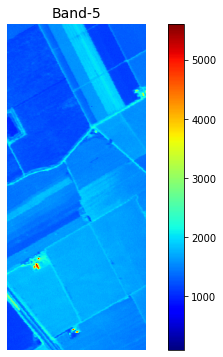

In [ ]:
def plot_band_no(dataset,band_no):
  plt.figure(figsize=(8, 6))
  plt.imshow(dataset[:,:, band_no], cmap='jet')
  plt.title(f'Band-{band_no}', fontsize=14)
  plt.axis('off')
  plt.colorbar()
  plt.show()

plot_band_no(sa_x1, 5)


## Training

In [ ]:
test = np.asarray([[2,5,16],[10,1,8]])
test.shape

(2, 3)

In [ ]:
ProtoModel = Prototypical(model,im_width, im_height, im_depth, im_channel)
optimizer = tf.keras.optimizers.Adam(0.00001)          #Adam(0.00001)
n_times = 10
std_list = []

In [ ]:
# Metrics to gather
train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')

def train_step(support, query, support_labels, query_labels, K, C, N):
    # Forward & update gradients
    with tf.GradientTape() as tape:
        loss, mean_accuracy, mean_predictions = ProtoModel(support, query, support_labels, query_labels, K, C, N,n_times,training=True)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Log loss and accuracy for step
    train_loss(loss)
    train_acc(mean_accuracy)

In [ ]:
checkpoint_dir = '/content/drive/My Drive/Hyperspectral Few Shot/Model checkpoints/Training checkpoints/Salinas/New_train_5_way_salinas_25_128'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 ProtoModel = ProtoModel)

In [ ]:
n_episodes = 100
temp_list = []
for epoch in range(300):
    train_loss.reset_states()
    train_acc.reset_states()
    for epi in range(n_episodes):
        tquery_patches, tsupport_patches, query_labels, support_labels = new_episode(patches_class_salinas,K1,C,N,train_class_labels)
        train_step(tsupport_patches, tquery_patches,support_labels, query_labels, K1, C, N)
    template = 'Epoch {}, Train Loss: {:.2f}, Train Accuracy: {:.2f}'
    print(template.format(epoch+1,train_loss.result(),train_acc.result()*100))
    if epoch % 20 == 0 and epoch != 0 :
        checkpoint.save(file_prefix = checkpoint_prefix)

Loop Number :  74
Dists :  tf.Tensor([2.7178512 2.0174572 3.5910196 1.3601398 1.7822274], shape=(5,), dtype=float32)
**********
New Distance :  tf.Tensor([1.8119007 1.3449715 2.3940132 0.9067599 1.1881516], shape=(5,), dtype=float32)
**********
Predictions :  tf.Tensor([0.13347578 0.2129057  0.07457518 0.32998952 0.24905388], shape=(5,), dtype=float32)
Loop Number :  74
Dists :  tf.Tensor([2.162866   1.7047743  3.8267674  0.94234484 1.5341594 ], shape=(5,), dtype=float32)
**********
New Distance :  tf.Tensor([1.4419107 1.1365162 2.5511782 0.6282299 1.0227729], shape=(5,), dtype=float32)
**********
Predictions :  tf.Tensor([0.15470757 0.20996298 0.05102262 0.3490508  0.23525605], shape=(5,), dtype=float32)
Loop Number :  74
Dists :  tf.Tensor([3.0207016 2.4500756 4.384652  1.5394571 2.4032192], shape=(5,), dtype=float32)
**********
New Distance :  tf.Tensor([2.013801  1.6333838 2.9231014 1.0263047 1.6021461], shape=(5,), dtype=float32)
**********
Predictions :  tf.Tensor([0.1416527  0.2

KeyboardInterrupt: ignored

## Tunning

In [ ]:
tune_set_5 = [[] for i in range(6)]
for j in range(6) :
  tune_set_5[j] = test_patches_class[j][:5,:,:,:,:]   # for each class first 5 samples taken
std_tune_5 = []

In [ ]:
def tune_episode(tune_set,tC,tK,tN,test_class_labels) :
  selected_classes = np.random.choice(test_class_labels,tC,replace=False)       # randomly selecting 4  classes from a list of 6 classes
  support_labels  = list(selected_classes)                                      # list of selected classes (int value)
  query_labels = []
  support_patches = []
  query_patches = []
  for x in selected_classes :
    y = test_class_labels.index(x)
    np.random.shuffle(tune_set[y])
    support_imgs = tune_set[y][:tK,:,:,:,:]    # Support 1 sample, Query 4 sample
    query_imgs = tune_set[y][tK:5,:,:,:,:]
    support_patches.extend(support_imgs)
    query_patches.extend(query_imgs)
    for i in range(tN) :
      query_labels.append(x)
  temp1 = list(zip(query_patches, query_labels))
  random.shuffle(temp1)
  query_patches, query_labels = zip(*temp1)
  query_patches = tf.convert_to_tensor(np.reshape(np.asarray(query_patches),(tC*tN,im_height,im_width,im_depth,1)),dtype=tf.float32)
  # print(query_patches.shape)
  support_patches = tf.convert_to_tensor(np.reshape(np.asarray(support_patches),(tC*tK,im_height,im_width,im_depth,1)),dtype=tf.float32)
  # print(support_patches.shape)
  return query_patches, support_patches, query_labels, support_labels

In [ ]:
query_patches, support_patches, query_labels, support_labels = tune_episode(tune_set_5,4,1,4,test_class_labels)

In [ ]:
# Metrics to gather
tune_loss = tf.metrics.Mean(name='tune_loss')
tune_acc = tf.metrics.Mean(name='tune_accuracy')

def tune_step(support, query, support_labels, query_labels, tK, tC, tN):
    # Forward & update gradients
    with tf.GradientTape() as tape:
        loss, mean_accuracy, mean_predictions = ProtoModel(support, query, support_labels, query_labels, tK, tC, tN,n_times,training=True)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Log loss and accuracy for step
    tune_loss(loss)
    tune_acc(mean_accuracy)

In [ ]:
checkpoint_dir1 = '/content/drive/My Drive/Hyperspectral Few Shot/Model checkpoints/Tuning checkpoints/Salinas/5_shot_updated/tuning_ckpts/New_tune_5_way_salinas_25_128'
checkpoint_prefix1 = os.path.join(checkpoint_dir1, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, ProtoModel = ProtoModel)

In [ ]:
n_episodes = 100
temp_list = []
for epoch in range(41): #140 tune + 120 tune + 40 tune + 40
    tune_loss.reset_states()  #130
    tune_acc.reset_states()
    for epi in range(n_episodes+1):
        tquery_patches, tsupport_patches, query_labels, support_labels = tune_episode(tune_set_5,3,1,4,test_class_labels)
        tune_step(tsupport_patches, tquery_patches,support_labels, query_labels, 1, 3, 4)
        template = 'Epoch {}, Tune Loss: {:.2f}, Tune Accuracy: {:.2f}'
        # print(template.format(epoch+1,tune_loss.result(),tune_acc.result()*100))
    if (epoch+1)%10 == 0 :
      checkpoint.save(file_prefix = checkpoint_prefix1)
      np.append(std_tune_5, temp_list)
      std_tune_5 = np.asarray(std_tune_5)
      # np.save('/content/drive/My Drive/Hyperspectral Few Shot/Model checkpoints/Tuning checkpoints/Salinas/5_shot_updated/std values/'+ str((epoch/20)+4)+'s_std_tune_5.npy',std_tune_5)
      np.save('/content/drive/My Drive/Hyperspectral Few Shot/Model checkpoints/Tuning checkpoints/Salinas/5_shot_updated/tuning_ckpts/New_tune_5_way_salinas_25_128/'+ str((epoch/20)+4)+'s_std_tune_5.npy',std_tune_5)
      std_tune_5 = std_tune_5.tolist()
      temp_list = []
    if (epoch+1)%10 == 0 :
      test_loss.reset_states()
      test_acc.reset_states()
      tquery_patches1, tsupport_patches1, query_labels1, support_labels1, x1 = test_episode(test_patches_class,test_class_labels,3,5,0,3)
      loss1, mc_predictions1, mean_accuracy1, classwise_mean_acc1, y1 = test_step(tsupport_patches1, tquery_patches1,support_labels1, query_labels1, 5, 3, x1/3)
#     print('OA1',mean_accuracy1)
# Class-wise Accuracy
      for i in range(tC) :
        print('class',i+1,classwise_mean_acc1[i])
#     print('loss',loss1)
      tquery_patches2, tsupport_patches2, query_labels2, support_labels2, x2 = test_episode(test_patches_class,test_class_labels,3,5,3,6)
      loss2, mc_predictions2, mean_accuracy2, classwise_mean_acc2, y2 = test_step(tsupport_patches2, tquery_patches2,support_labels2, query_labels2, 5, 3, x2/3)
#    print('OA2',mean_accuracy2)
# Class-wise Accuracy
      for i in range(tC) :
        print('class',i+4,classwise_mean_acc2[i])#
#    print('loss',loss2)
      mean_predictions1 =  tf.reduce_mean(mc_predictions1,axis=0)
      mean_predictions2 =  tf.reduce_mean(mc_predictions2,axis=0)
      overall_predictions = tf.concat([mean_predictions1,mean_predictions2],axis=0)
      overall_true_labels = tf.concat([y1,y2],axis=0)
      correct_pred = tf.cast(tf.equal(                                             # accuracy for the current pass
            tf.cast(tf.argmax(overall_predictions, axis=-1), tf.int32),
            tf.cast(tf.argmax(overall_true_labels,axis=-1), tf.int32)), tf.float32)
      o_acc = tf.reduce_mean(correct_pred)
      print("Overall accuracy:",o_acc)

## Testing

In [ ]:
def test_episode(test_patches_class,test_class_labels,test_C,test_K,i,f) :
  selected_classes = test_class_labels[i:f]   # [1, 2, 3, 4, 5, 6, 7, 8]
  support_labels = list(selected_classes)
  query_labels = []
  support_patches = []
  query_patches = []
  for x in selected_classes :
    y = test_class_labels.index(x)
    support_imgs = test_patches_class[y][:test_K,:,:,:,:]
    query_imgs = test_patches_class[y][test_K:,:,:,:,:]
    support_patches.extend(support_imgs)
    query_patches.extend(query_imgs)
    for i in range(query_imgs.shape[0]) :
      query_labels.append(x)
  temp1 = list(zip(query_patches, query_labels))
  random.shuffle(temp1)
  query_patches, query_labels = zip(*temp1)
  x = len(query_labels)
  query_patches = tf.convert_to_tensor(np.reshape(np.asarray(query_patches),(x,im_height,im_width,im_depth,1)),dtype=tf.float32)
  support_patches = tf.convert_to_tensor(np.reshape(np.asarray(support_patches),(test_C*test_K,im_height,im_width,im_depth,1)),dtype=tf.float32)
  return query_patches, support_patches, query_labels, support_labels,x

In [ ]:
query_patches, support_patches, query_labels, support_labels,x = test_episode(test_patches_class,test_class_labels,3,5,0,3)

In [ ]:
# Metrics to gather
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')
def test_step(support, query, support_labels, query_labels, K, C, v):
    loss, mc_predictions, mean_accuracy, classwise_mean_acc, y = ProtoModel(support, query, support_labels, query_labels, K, C, v,n_times,training=False)
    return loss, mc_predictions, mean_accuracy, classwise_mean_acc, y

In [ ]:
for epoch in range(1): #1000
    test_loss.reset_states()
    test_acc.reset_states()
    tquery_patches1, tsupport_patches1, query_labels1, support_labels1, x1 = test_episode(test_patches_class,test_class_labels,3,5,0,3)
    loss1, mc_predictions1, mean_accuracy1, classwise_mean_acc1, y1 = test_step(tsupport_patches1, tquery_patches1,support_labels1, query_labels1, 5, 3, x1/3)
#    print('OA1',mean_accuracy1)
# Class-wise Accuracy
    for i in range(tC) :
      print('class',i+1,classwise_mean_acc1[i])
#    print('loss',loss1)
    tquery_patches2, tsupport_patches2, query_labels2, support_labels2, x2 = test_episode(test_patches_class,test_class_labels,3,5,3,6)
    loss2, mc_predictions2, mean_accuracy2, classwise_mean_acc2, y2 = test_step(tsupport_patches2, tquery_patches2,support_labels2, query_labels2, 5, 3, x2/3)
#    print('OA2',mean_accuracy2)
# Class-wise Accuracy
    for i in range(tC) :
      print('class',i+4,classwise_mean_acc2[i])#
#    print('loss',loss2)
    mean_predictions1 =  tf.reduce_mean(mc_predictions1,axis=0)
    mean_predictions2 =  tf.reduce_mean(mc_predictions2,axis=0)
    overall_predictions = tf.concat([mean_predictions1,mean_predictions2],axis=0)
    overall_true_labels = tf.concat([y1,y2],axis=0)
    correct_pred = tf.cast(tf.equal(                                             # accuracy for the current pass
            tf.cast(tf.argmax(overall_predictions, axis=-1), tf.int32),
            tf.cast(tf.argmax(overall_true_labels,axis=-1), tf.int32)), tf.float32)
    o_acc = tf.reduce_mean(correct_pred)
    print("Overall accuracy:",o_acc)

## Overall Accuracy

In [ ]:
mean_predictions1 =  tf.reduce_mean(mc_predictions1,axis=0)
mean_predictions2 =  tf.reduce_mean(mc_predictions2,axis=0)
overall_predictions = tf.concat([mean_predictions1,mean_predictions2],axis=0)
overall_true_labels = tf.concat([y1,y2],axis=0)
correct_pred = tf.cast(tf.equal(                                             # accuracy for the current pass
            tf.cast(tf.argmax(overall_predictions, axis=-1), tf.int32),
            tf.cast(tf.argmax(overall_true_labels,axis=-1), tf.int32)), tf.float32)
o_acc = tf.reduce_mean(correct_pred)
print("Overall accuracy:",o_acc)

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
mean_predictions1 =  tf.reduce_mean(mc_predictions1,axis=0)
cm_pred1 = tf.argmax(mean_predictions1, axis=-1)
mean_predictions2 =  tf.reduce_mean(mc_predictions2,axis=0)
cm_pred2 = tf.argmax(mean_predictions2, axis=-1) + 3
overall_predictions = tf.concat([cm_pred1,cm_pred2],axis=0)
cm_true1 = tf.argmax(y1,axis=-1)
cm_true2 = tf.argmax(y2,axis=-1) + 3
overall_true_labels = tf.concat([cm_true1,cm_true2],axis=0)
results = confusion_matrix(overall_true_labels,overall_predictions)
print ('Confusion Matrix :')
print(results)
print ('Report : ')
print (classification_report(overall_true_labels, overall_predictions))

## Kappa

In [ ]:
import sklearn
sklearn.metrics.cohen_kappa_score(overall_true_labels,overall_predictions)